Pour démarer la présentation : `jupyter nbconvert --config=Configuration.py Presentation.ipynb`

In [1]:
from sklearn import datasets, metrics, svm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


# Validation croisée ✅

Présenté par Alix ANNERAUD et Hugo TONDENIER.

# 1. Principe 🔍

Qu'est-ce que la validation croisée et pourquoi est-elle utile ?

## 📖 Définition

> 🧔 : *"Qu'est ce que la vérification croisée ?"*

> 🤖 : *"La vérification croisée, aussi connue sous le nom de validation croisée, est une technique utilisée en machine learning pour évaluer la performance d'un modèle. L'objectif principal est de vérifier comment les résultats d'un modèle généré à partir d'un jeu de données donné vont généraliser sur un jeu de données indépendant.Voici comment cela fonctionne en général :

## 🏃 Entraînement d'un modèle

<img style="height: 500px;display: block;margin-left: auto;margin-right: auto;" src="Model_training.svg" alt="Model_training.svg" />

### 👶 Approche naïve

```mermaid
sankey-beta

%% source,target,value
Donnees,Entrainement,90.0
Donnees,Validation,10.0
```

- ✅ Simple.
- ❌ Biaisé.
- ❌ Pas toutes les données sont utilisées pour l'entraînement.

### 🔢 Validation croisée à $k$ blocs (k-fold)

<img style="height: 400px;display: block;margin-left: auto;margin-right: auto;" src="K_fold.svg" alt="Model_training.svg" />

- ✅ Production de $k$ modèles.
- ✅ Utilisation de toutes les données.
- ✅ Plus robuste.
- ⚠️ Certains plis peuvent être biaisés.
- ❌ Augmentation du temps de calcul.

### 🔀 Validation croisée par séparation aléatoire (shuffle-split)

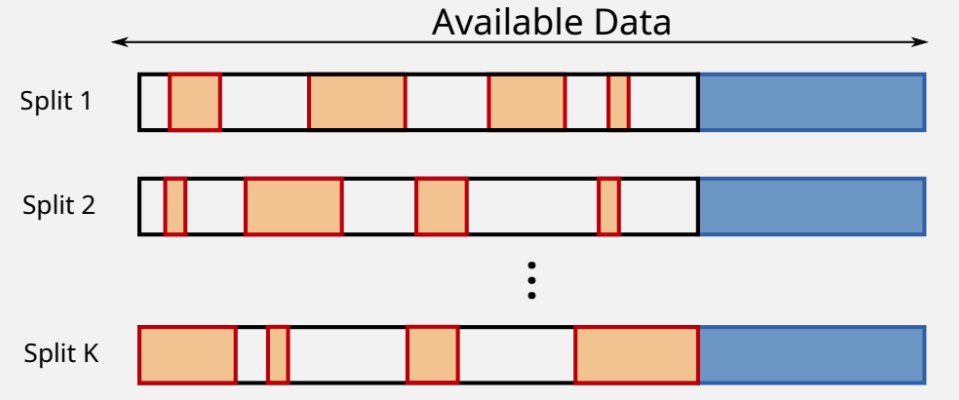

- ✅ Production de K modèles.
- ✅ Evite le biais des plis.
- ⚠️ Certaines données peuvent être utilisées plusieurs fois / pas du tout.
- ❌ Augmentation du temps de calcul


## ☢️ Sur-ajustement

Modèle trop spécifique aux données d'entraînement : mauvaise généralisation.

A cause de : 
- Jeu de données biaisé (trop petit, non représentatif, etc.)
- Trop grande liberté du modèle (mauvais ajustement des hyperparamètres).

In [2]:
# Génération de données synthétiques
np.random.seed(0)
X = np.sort(np.random.rand(20) * 10)
y = np.sin(X) + np.random.randn(20) * 0.5

def regression_polynomiale(X, y, X_prediction, degre):
    # Création du modèle
    model = make_pipeline(PolynomialFeatures(degre), LinearRegression())
    model.fit(X[:, np.newaxis], y)
    return model.predict(X_prediction[:, np.newaxis])

degrees = [1, 5, 10]

X_plot = np.linspace(0, 10, 100)

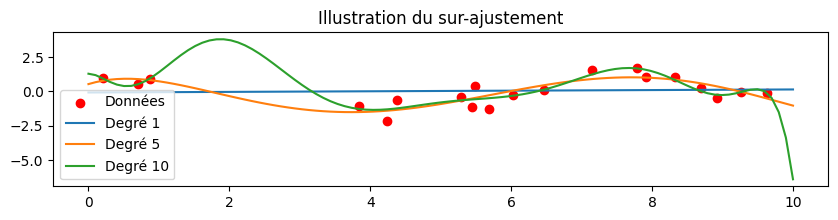

In [3]:
plt.figure(figsize=(10, 2))
plt.scatter(X, y, color='red', label='Données');

for degree in degrees:
    plt.plot(X_plot, regression_polynomiale(X, y, X_plot, degree), label=f'Degré {degree}');

plt.title('Illustration du sur-ajustement');
plt.legend();

## Reprérer le sur-ajustement

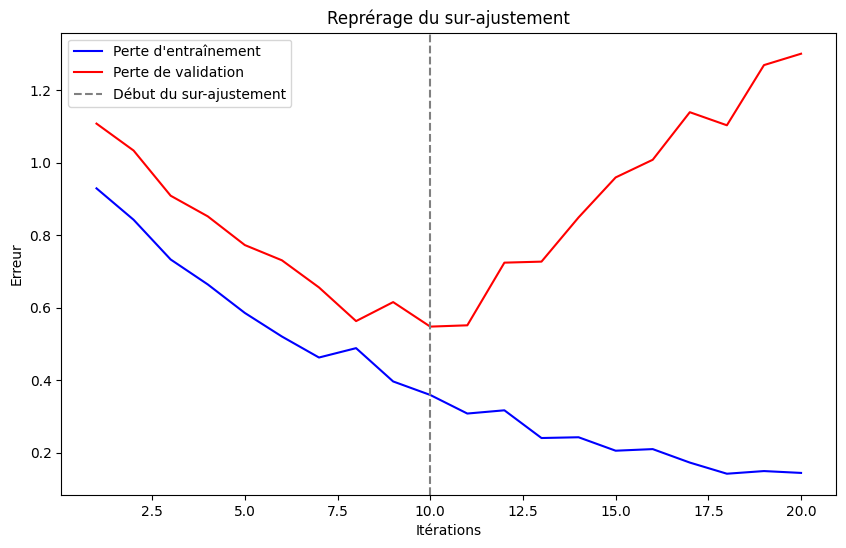

In [4]:
# Simuler des pertes d'entraînement et de validation
epochs = np.arange(1, 21)
training_loss = np.exp(-epochs / 10) + 0.02 * np.random.randn(20)
validation_loss = np.exp(-epochs / 10) + 0.05 * np.random.randn(20) + 0.2

# Introduire le sur-ajustement artificiellement
validation_loss[10:] += 0.1 * (epochs[10:] - 10)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b-', label='Perte d\'entraînement')
plt.plot(epochs, validation_loss, 'r-', label='Perte de validation')
plt.axvline(x=10, color='gray', linestyle='--', label='Début du sur-ajustement')

plt.title('Reprérage du sur-ajustement')
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.legend()
plt.show()


## ✅ Validation croisée
> - 🤖 : **Processus de Validation Croisée :**
>   - **Division des Données :**
>     Le jeu de données initial est divisé en plusieurs sous-ensembles ou "folds". Une division courante est la validation croisée k-fold, où les données sont divisées en k sous-ensembles.
>   - **Entraînement et Validation :**
>     Pour chaque itération, un des k sous-ensembles est utilisé comme jeu de validation, et les k-1 autres sous-ensembles sont utilisés comme jeu d'entraînement. Ce processus est répété k fois, chaque sous-ensemble servant exactement une fois de jeu de validation.
>   - **Évaluation :**
>     À chaque itération, le modèle est évalué sur le jeu de validation et les performances (par exemple, précision, rappel, F1-score) sont enregistrées.
>   - **Agrégation des Résultats :**
>     Après k itérations, les résultats des k évaluations sont agrégés pour donner une estimation globale de la performance du modèle. Cela peut être fait en calculant la moyenne des performances des k itérations.




# 2. Exemple 👀

## 📊 Jeu de données

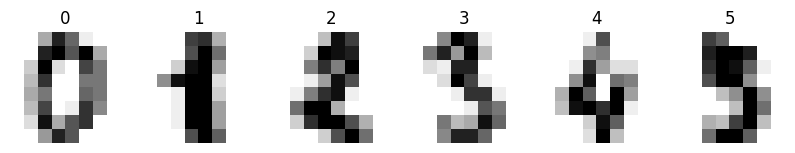

In [5]:
chiffres = datasets.load_digits()   # Importation du jeu de données

# Affichage des 6 premières images
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 5))
for ax, image, label in zip(axes, chiffres.images, chiffres.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title("%i" % label)

# "Aplatissement" des images (2D) en vecteurs de caractéristiques (1D)
n_samples = len(chiffres.images)
data = chiffres.images.reshape((n_samples, -1))

In [6]:
# Division en ensembles d'entraînement et de test
X_entrainement, X_test, y_entrainement, y_test =\
    train_test_split(data, chiffres.target, test_size=0.3, shuffle=False)

## 📈 Exemple de surapprentissage

In [7]:
maximum_iterations = np.logspace(1, 3, 10, dtype=int)
precisions = []

for max_iter in maximum_iterations:
    # - Création et entraînement du modèle
    regression = LogisticRegression(max_iter=max_iter)
    regression.fit(X_entrainement, y_entrainement)

    # - Prédiction du model sur le jeu de test
    predictions = regression.predict(X_test)

    # - Calcul de la précision du modèle
    precisions.append(accuracy_score(y_test, predictions))

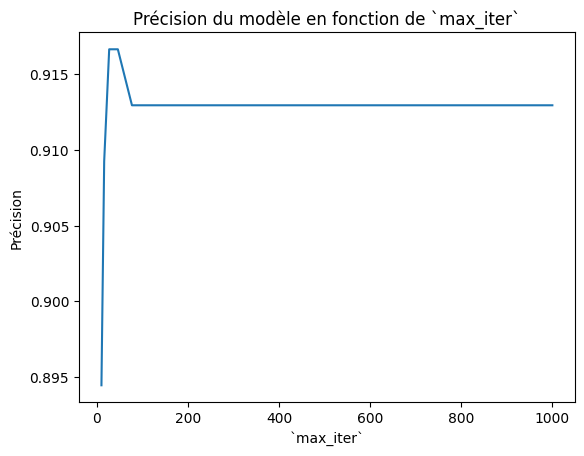

In [8]:
# - Affichage des précisions
plt.plot(maximum_iterations, precisions);
plt.xlabel('`max_iter`')
plt.ylabel('Précision')
plt.title('Précision du modèle en fonction de `max_iter`');

## Intervention de la Validation Croisée

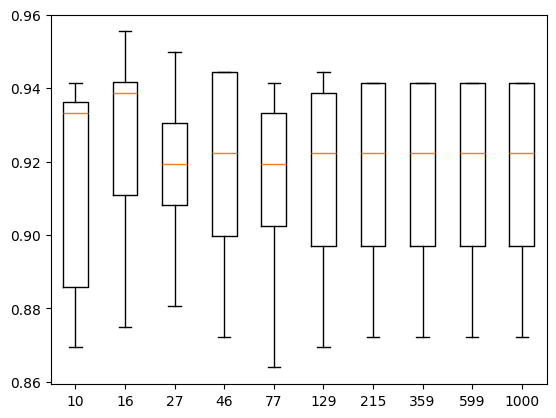

In [9]:
precisions = {}

for  max_iter in maximum_iterations:
    # - Création et entraînement du modèle
    regression = LogisticRegression(max_iter=max_iter)
    regression.fit(X_entrainement, y_entrainement)

    # - Prédiction du model sur le jeu de test
    predictions = regression.predict(X_test)

    # - Calcul de la précision du modèle
    precision = cross_val_score(regression, data,\
                                chiffres.target, cv=5, scoring='accuracy')

    precisions[str(max_iter)] = precision


_, axes = plt.subplots();
axes.boxplot(precisions.values());
axes.set_xticklabels(precisions.keys());

## Cas concret de recherche des paramètre avec un SVC  
la fonction gridsearchCV calcule des scores en utilisant la validation croisé pour une matrice de paramètres 

In [26]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Plus C est élevé, plus la régularisation est faible
    'gamma': [0.001, 0.01, 0.1, 1],  # Plus gamma est élevé, plus le modèle est complexe
    'kernel': ['rbf', 'poly', 'sigmoid']  # Types de noyaux à tester
}

# Création du modèle SVM avec GridSearchCV
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5,\
                            scoring='accuracy', verbose=1)
grid_search.fit(X_entrainement, y_entrainement);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [11]:
# Affichage des meilleurs paramètres
print("Best parameters found: ", grid_search.best_params_)
best_svm = grid_search.best_estimator_

# Prédiction et évaluation sur l'ensemble de test
predictions = best_svm.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, predictions) * 100))

Best parameters found:  {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 97.04%


# Nous vous remercions pour votre attention 🙏